This notebook is a test for propagation of pure protons, with different interactions enabled/disabled

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import prince_cr.config
from prince_cr import core, util, photonfields, cross_sections
from prince_cr import util as pru

# Create a PriNCeRun object with max mass set to 1

In [5]:
%%time

prince_cr.config.max_mass = 1
prince_cr.config.secondaries = True
prince_cr.config.x_cut = 1e-6
prince_cr.config.x_cut_proton = 1e-3
# Format (log10(E_min), log10(E_max), nbins/decade of energy)
# Main energy grid for solver
prince_cr.config.cosmic_ray_grid = (3, 14, 8)
# Photon grid of target field, only for calculation of rates
prince_cr.config.photon_grid = (-15, -6, 8)
prince_cr.config.linear_algebra_backend = 'MKL'

pf = photonfields.CMBPhotonSpectrum()
cs = cross_sections.CompositeCrossSection(
             [(0., cross_sections.TabulatedCrossSection, ()),
              (0.14, cross_sections.SophiaSuperposition, ())])
prince_run = core.PriNCeRun(photon_field=pf,cross_sections=cs)

CompositeCrossSection::_join_models(): Attempt to join 2 models.
PriNCeRun::__init__(): initialising Energy grid
PhotoNuclearInteractionRate::_init_coupling_mat(): Initiating coupling matrix in (CSR) format
Wall time: 2.32 s


# Run solvers with different interactions enabled

In [6]:
%%time
from prince_cr.solvers import UHECRPropagationSolverBDF as SolClass
from prince_cr.cr_sources import SimpleSource

initial_z = 1.
final_z = 0.
norm = 1.
source = SimpleSource(prince_run,params={101: (2.5,1e12,1.)}, norm=1.,m=0.)

sol_adiabatic = SolClass(initial_z=initial_z, final_z =final_z,prince_run=prince_run,
                         enable_pairprod_losses = False,
                         enable_adiabatic_losses = True,
                         enable_photohad_losses = False)
sol_adiabatic.add_source_class(source)

sol_pairprod = SolClass(initial_z=initial_z, final_z =final_z,prince_run=prince_run,
                        enable_pairprod_losses = True,
                        enable_adiabatic_losses = True,
                        enable_photohad_losses = False)
sol_pairprod.add_source_class(source)

sol_photohad = SolClass(initial_z=initial_z, final_z =final_z,prince_run=prince_run,
                        enable_pairprod_losses = False,
                        enable_adiabatic_losses = True,
                        enable_photohad_losses = True)
sol_photohad.add_source_class(source)

sol_alllosses = SolClass(initial_z=initial_z, final_z =final_z,prince_run=prince_run,
                         enable_pairprod_losses = True,
                         enable_adiabatic_losses = True,
                         enable_photohad_losses = True)
sol_alllosses.add_source_class(source)

for solver in [sol_adiabatic, sol_pairprod, sol_photohad, sol_alllosses]:
    solver.solve(dz=1e-3,verbose=False,full_reset=False, progressbar=True)
    print(solver.list_of_sources)
    print('finished solving for', str(solver))

solver_d2 = [sol_adiabatic, sol_pairprod, sol_photohad, sol_alllosses]

1007it [00:00, 1970.20it/s]                                                                                            
 17%|████████████▌                                                               | 166/1000.0 [00:00<00:01, 827.96it/s]

finished solving for <prince_cr.solvers.propagation.UHECRPropagationSolverBDF object at 0x000002518373B308>


1007it [00:01, 821.52it/s]                                                                                             
 37%|███████████████████████████▊                                               | 371/1000.0 [00:00<00:00, 1807.71it/s]

finished solving for <prince_cr.solvers.propagation.UHECRPropagationSolverBDF object at 0x000002518373B688>


1007it [00:00, 1925.00it/s]                                                                                            
 15%|███████████▍                                                                | 151/1000.0 [00:00<00:01, 734.63it/s]

finished solving for <prince_cr.solvers.propagation.UHECRPropagationSolverBDF object at 0x000002518373BAC8>


1007it [00:01, 796.18it/s]                                                                                             

finished solving for <prince_cr.solvers.propagation.UHECRPropagationSolverBDF object at 0x000002518373BA08>
Wall time: 3.57 s


# Normalize and plot the results

In [7]:
results = []
for solver in [sol_adiabatic, sol_pairprod, sol_photohad, sol_alllosses]:
    result = solver.res
    egrid, spec = result.get_solution_group('CR')
    norm = 1e2/spec[(np.abs(egrid - 1e8)).argmin()]
    print(f'{norm:.2e}')
    
    result = result * norm
    results.append(result)

res_adiabatic, res_pairprod, res_photohad, res_alllosses = results

2.09e-20
2.08e-20
2.09e-20
2.08e-20


No handles with labels found to put in legend.


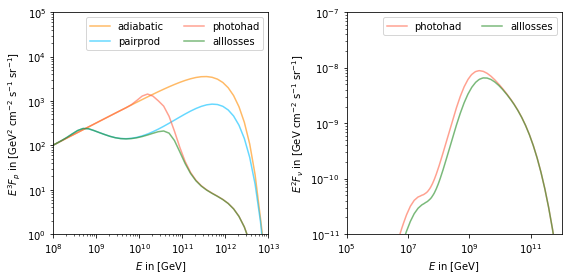

In [8]:
fig, ax = plt.subplots(1,2, figsize = (8,4))

#----------------------------------------------
# compare contributions cosmic rays
#----------------------------------------------
plt.sca(ax[0])

for (result, label, color) in zip([res_adiabatic, res_pairprod, res_photohad, res_alllosses],
                                  ['adiabatic', 'pairprod', 'photohad', 'alllosses'],
                                  ['darkorange','deepskyblue','tomato','forestgreen']):
    energy, spectrum = result.get_solution_scale(101,epow=3)
    l = plt.loglog(energy, spectrum, label=label, c=color, alpha = 0.6)

plt.legend(ncol=2)#, fontsize='xx-small')

plt.ylabel(r'$E^3 F_p$ in [GeV$^2$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
plt.ylim(1e0,1e5)
plt.xlabel(r'$E$ in [GeV]')
plt.xlim(1e8,1e13)

#----------------------------------------------
# compare contributions neutrinos
#----------------------------------------------
plt.sca(ax[1])

plt.loglog()
plt.legend(ncol=3)#, fontsize='xx-small')

for (result, label, color) in zip([
    res_photohad, res_alllosses],
                                  ['photohad', 'alllosses'],
                                  ['tomato','forestgreen']):
    energy, spectrum = result.get_solution_group([11,12,13,14],epow=2)
    l = plt.loglog(energy, spectrum, label=label, c=color, alpha = 0.6)

plt.legend(ncol=2)#, fontsize='xx-small')

plt.ylabel(r'$E^2 F_\nu$ in [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
plt.ylim(1e-11,1e-7)
plt.xlim(1e5,1e12)
plt.xlabel(r'$E$ in [GeV]')

plt.tight_layout()

# Exact adiabatic solution:

The adaibatic solution at $z = 0$ is simply calculated by integration of the injection:
$$
n(E, z = 0) = \int_0^{z_{max}} dz^\prime \frac{1}{H(z^\prime)} \mathcal{L}_{inj}(\epsilon (1 + z^\prime), z^\prime)
$$

This results should be retained by the solver that has only adiabatic losses enabled.

In [12]:
%%time
from prince_cr.solvers import UHECRPropagationSolverEULER as SolClass
from prince_cr.cr_sources import SimpleSource

initial_z = 1.
final_z = 0.
norm = 1.
source = SimpleSource(prince_run,params={101: (2.5,1e12,1.)}, norm=1.,m=0.)

sol_adiabatic = SolClass(initial_z=initial_z, final_z =final_z,prince_run=prince_run,
                         enable_pairprod_losses = False,
                         enable_adiabatic_losses = True,
                         enable_photohad_losses = False,
                        enable_partial_diff_jacobian=True)
sol_adiabatic.add_source_class(source)

sol_adiabatic.solve(dz=1e-3,verbose=False)

Wall time: 2.27 s


Wall time: 91.5 ms


(1e+20, 1e+24)

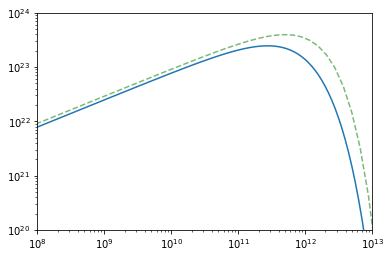

In [13]:
%%time

source = SimpleSource(prince_run,params={101: (2.5, 1e12, 1.)}, norm=1.,m=0.)

injection = source.injection_rate_single
injection = np.vectorize(injection,excluded=[0])

egrid = np.logspace(8,13,100)
z_steps = np.linspace(0,5,100)

from prince_cr.cosmology import H
from scipy.integrate import trapz

einj = np.outer(egrid, 1 + z_steps)
z_prime = np.outer(1, z_steps)
inj = injection(101,einj, z_prime)
H_factor = H(z_prime)

spectrum = trapz(inj / H_factor, z_steps ,axis = 1)

plt.loglog(egrid, egrid**3 * spectrum)

energy, spectrum = sol_adiabatic.res.get_solution_scale(101,epow=3)
plt.loglog(energy, spectrum, label=label, c=color, alpha = 0.6,ls='dashed')

plt.xlim(1e8,1e13)
plt.ylim(1e20,1e24)